In [1]:
# set to true to recompute BP positions from raw data

recompute = False

---

In [2]:
from pathlib import Path
import micromagneticdata as mdata
import os
import ast
import discretisedfield as df
from multiprocessing import Pool
import matplotlib.pyplot as plt
import discretisedfield as df
import json
import numpy as np
import itertools
from matplotlib.patches import ArrowStyle
import pandas as pd

In [3]:
name = 'mbp_l_600_w_{}_ht_10_ix'

In [4]:
if recompute:
    paths = sorted(Path('simulations/').glob('J*'), key=lambda p: float(p.name[2:]))

    paths

In [5]:
widths = [100, 125, 150]

In [6]:
if recompute:
    data1 = mdata.Data(name='mbp_l_600_w_100_ht_10_ix', dirname='simulations/J_1.1e+12')
    data2 = mdata.Data(name='mbp_l_600_w_100_ht_10_ix', dirname='simulations/J_1.2e+12')
    
    def locate(filename):
        m = df.Field.from_file(filename)
        pos_x = ast.literal_eval(df.tools.count_bps(m)['bp_pattern_x'])[0][1] * 2.5
        pos_y = ast.literal_eval(df.tools.count_bps(m, direction='y')['bp_pattern_y'])[0][1] * 2.5
        return [pos_x, pos_y]

    with Pool(len(os.sched_getaffinity(0))) as p:
        res1 = p.map(locate, data1[0]._step_files)
    with Pool(16) as p:
        res2 = p.map(locate, data2[0]._step_files)
    
    pd.DataFrame({'t': data2[0].table.data['t'], 'pos_x': np.array(res2)[:,0], 'pos_y': np.array(res2)[:,1]}).to_csv('res2.csv', index=False)
    pd.DataFrame({'t': data2[0].table.data['t'], 'pos_x': np.array(res2)[:,0], 'pos_y': np.array(res2)[:,1]}).to_csv('res2.csv', index=False)
else:
    res1 = pd.read_csv('res1.csv')
    res2 = pd.read_csv('res2.csv')    

In [7]:
solid_wire = df.Field.from_file('current-100.omf')
solid_wire.valid = 'norm'
solid_wire.array[~solid_wire.valid] = np.nan

Text(5, 110, 'c')

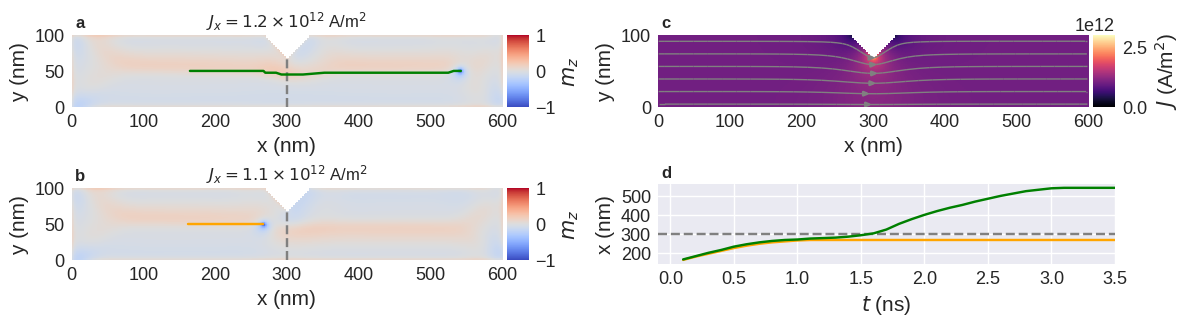

In [8]:
layout = [
    ["strong", "profile"],
    ["weak", "time"],
]
fig, axs = plt.subplot_mosaic(layout, layout='tight', figsize=(12, 3.3))
c1 = 'orange'
c2 = 'green'

ax = axs['weak']
ax.set_facecolor('white')
ax.axvline(300, 0, 0.7, linestyle='--', c='grey')
m = df.Field.from_file('m1.omf').orientation
m.valid = 'norm'
m.z.sel(z=1e-9).mpl.scalar(ax=ax, clim=(-1, 1), cmap='coolwarm', colorbar_label='$m_z$')
ax.plot(res1['pos_x'], res1['pos_y'], '-', c=c1)
ax.set_title(r'$J_x=1.1\times10^{12}$ A/m$^2$', fontsize='large')
ax.text(5, 110, 'b', fontsize='large', fontweight='bold')

ax = axs['strong']
ax.axvline(300, 0, 0.7, linestyle='--', c='grey')
m = df.Field.from_file('m2.omf').orientation
m.valid = 'norm'
m.z.sel(z=1e-9).mpl.scalar(ax=ax, clim=(-1, 1), cmap='coolwarm', colorbar_label='$m_z$')
ax.plot(res2['pos_x'], res2['pos_y'], '-', c=c2)
ax.set_title(r'$J_x=1.2\times10^{12}$ A/m$^2$', fontsize='large')
ax.set_facecolor('white')
ax.text(5, 110, 'a', fontsize='large', fontweight='bold')

ax = axs['time']
ax.axhline(300, c='grey', linestyle='--')
ax.plot(res1['t'] * 1e9, res1['pos_x'], c=c1, label=r'$J_x=1.1\times10^{12}$ A/m$^2$')
ax.plot(res2['t'] * 1e9, res2['pos_x'], c=c2, label=r'$J_x=1.2\times10^{12}$ A/m$^2$')
ax.grid()
ax.set_xlabel('$t$ (ns)')
ax.set_ylabel('x (nm)')
ax.set_yticks([200, 300, 400, 500])
ax.set_xlim((-.1, 3.5))
ax.text(-.07, 600, 'd', fontsize='large', fontweight='bold')

ax = axs['profile']
solid_wire.sel('z').norm.mpl.scalar(ax=ax, cmap='magma', colorbar_label='$J$ (A/m$^2$)', clim=(0, 3e12))
ax.set_facecolor('white')
start = 1
step = 7
sp = ax.streamplot(
    solid_wire.mesh.points.x, solid_wire.mesh.points.y,
    solid_wire.sel('z').x.array.squeeze().T, solid_wire.sel('z').y.array.squeeze().T,
    start_points=list(zip(itertools.repeat(10), solid_wire.mesh.points.y[start::step])),
    color='grey', broken_streamlines=False, arrowstyle=ArrowStyle.Simple(tail_width=0.01, head_width=0.25, head_length=0.3)
)
sp.lines.set_linewidth(1)
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
ax.text(5, 110, 'c', fontsize='large', fontweight='bold')

In [9]:
fig.savefig('Fig3.pdf')

---

In [10]:
if recompute:
    final_pos = {w: [] for w in widths}

    for path in paths:
        print(path)
        for width in widths:
            data = mdata.Data(name=name.format(width), dirname=str(path))

            mf = data[0][-1]
            pos = ast.literal_eval(df.tools.count_bps(mf)['bp_pattern_x'])[0][1]
            final_pos[width].append(pos * 2.5e-9)
            
else:
    with open("final-pos.json") as f:
        final_pos = json.load(f, object_pairs_hook=lambda x: {int(k): v for k, v in x})

In [11]:
if recompute:
    intermediate_pos = {w: [] for w in widths}

    for path in paths:
        print(path)
        for width in widths:
            data = mdata.Data(name=name.format(width), dirname=str(path))

            mf = data[0][-10]
            pos = ast.literal_eval(df.tools.count_bps(mf)['bp_pattern_x'])[0][1]
            intermediate_pos[width].append(pos * 2.5e-9)
            
else:
    with open("intermediate-pos.json") as f:
        intermediate_pos = json.load(f, object_pairs_hook=lambda x: {int(k): v for k, v in x})

In [12]:
js = [2e+11, 4e+11, 6e+11, 7e+11, 8e+11, 9e+11, 1e+12, 1.1e+12, 1.2e+12, 1.5e+12, 2e+12, 3e+12]

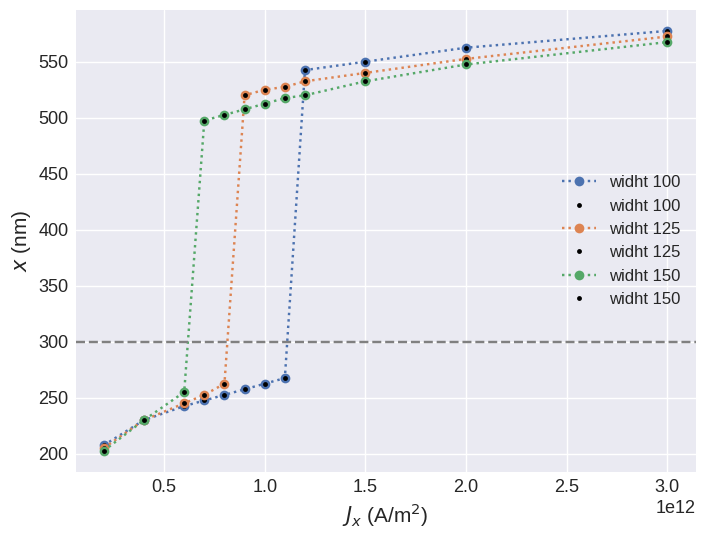

In [13]:
# check: BP has reached steady state at the end of the simulation

for width in widths:
    plt.plot(np.array(js), np.array(final_pos[width]) / 1e-9, ':o', label=f"widht {width}")
    plt.plot(np.array(js), np.array(intermediate_pos[width]) / 1e-9, '.', label=f"widht {width}", c='k')
plt.axhline(300, linestyle='--', c='grey')
plt.xlabel("$J_x$ (A/m$^2$)")
plt.ylabel("$x$ (nm)")
plt.legend()
plt.grid()

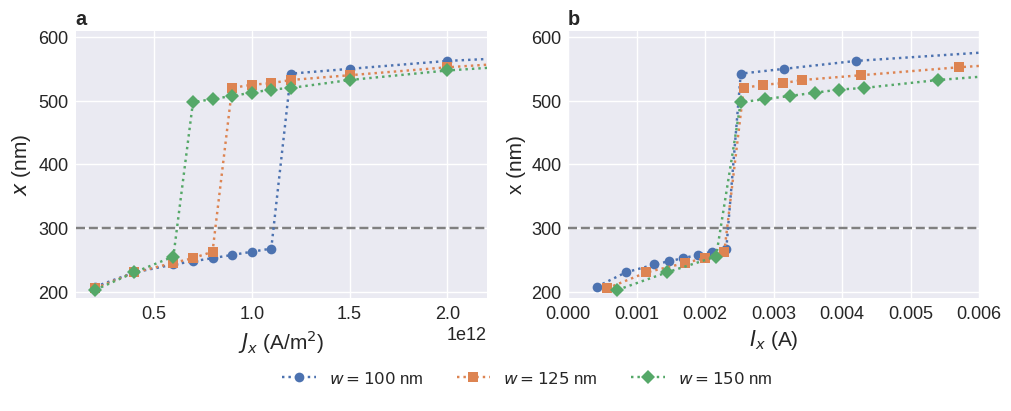

In [14]:
mosaic = """
ab
ll
"""
fig, axs = plt.subplot_mosaic(mosaic, gridspec_kw={'height_ratios': (5, .5)}, figsize=(10, 4), layout='constrained')

ax = axs["a"]
ax.axhline(300, linestyle='--', c='grey')
for width, marker in zip(widths, "osD"):
    ax.plot(np.array(js), np.array(final_pos[width]) / 1e-9, ':', marker=marker)
ax.set_xlabel("$J_x$ (A/m$^2$)")
ax.set_ylabel("$x$ (nm)")
ax.set_xlim((0.1e12, 2.2e12))
ax.set_ylim((190, 610))
ax.grid()
ax.text(0.1e12, 620, 'a', fontweight='bold', fontsize='x-large')

ax = axs["b"]
ax.axhline(300, linestyle='--', c='grey')
handles = []
for width, marker in zip(widths, 'osD'):
    line, = ax.plot(np.array(js) * (width - 30)*1e-9*30e-9, np.array(final_pos[width]) / 1e-9, ':', label=f"$w={width}$ nm", marker=marker)
    handles.append(line)
ax.set_xlabel("$I_x$ (A)")
ax.set_ylabel("x (nm)")
ax.set_xlim((0, 6e-3))
ax.set_ylim((190, 610))
#plt.ylim((220, 280))
ax.grid()
ax.text(0, 620, 'b', fontweight='bold', fontsize='x-large')


axs["l"].legend(handles=handles, ncols=3, loc='lower center')
axs["l"].axison = False

In [15]:
fig.savefig('Fig4.pdf')